## Project 4: Collaborative Filtering via Gaussian Mixtures

### 2. K-Means

For this part of the project you will compare clustering obtained via K-means to the (soft) clustering induced by EM. In order to do so, our K-means algorithm will differ a bit from the one you learned. Here, the means are estimated exactly as before but the algorithm returns additional information. More specifically, we use the resulting clusters of points to estimate a Gaussian model for each cluster. Thus, our K-means algorithm actually returns a mixture model where the means of the component Gaussians are the $K$ centroids computed by the K-means algorithm. This is to make it such that we can now directly plot and compare solutions returned by the two algorithms as if they were both estimating mixtures.

Final Cost: 1035.499826539466


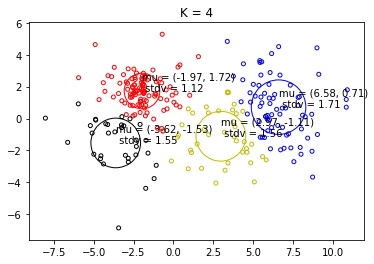

In [2]:
import numpy as np
from typing import List, Dict, Tuple, Optional
from netflix import kmeans, common
from netflix.common import GaussianMixture

# Read a 2D toy dataset 
X : np.ndarray = np.loadtxt('./netflix/toy_data.txt')

# Setup the number of clusters
clusters = 4

# Initialize the K-means algorithm using the implementation in "kmeans.py"
# It returns the initialized gaussian mixture
init_results : Tuple[GaussianMixture, np.ndarray] = common.init(X, K = clusters, seed = 4)

# Run the actual KMeans algorithm
algo_results : Tuple[GaussianMixture, np.ndarray, float] = kmeans.run(X, init_results[0], init_results[1]) 

# Print the cost
cost : float = algo_results[2]
print("Final Cost:", cost)

# Plot the solution
common.plot(X, algo_results[0], algo_results[1], title = f"K = {clusters}")

### 3. Expectation-maximization Algorithm

In [44]:
from typing import Tuple
import numpy as np

# ==============================
# E-STEP
# ==============================

def estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component

    Args:
        X: (n, d) array holding the data
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment
    """

    # Get the means, variances and the mixing proportions out of the mixture
    # "NamedTuple"
    mu, var, p = mixture

    # Normal equation
    # mu_j: Mean of mixture "j"
    # var_j: Variance of mixture "j"
    N = lambda x, mu_j, var_j : (1 / np.sqrt(2*np.pi*var_j)) * np.exp(-(np.linalg.norm(x - mu_j, axis=1)**2)/(2*var_j))

    # NOTE: We use the square of "np.linalg.norm" to get the sum of the squares of each
    # component of each data point in "X". This means that if a data point in X is [1, 2]
    # and the mean is [1, 1], np.linalg.norm(x - mu, axis=1)**2 will be equal to:
    # (1 - 1)^2 + (2 - 1)^2 = 1

    # Probability of a sample being generated by each mixture
    pj_times_likelihood_all_x = []
    for xi in X:

        # Get the probability that a data point "xi" was generated by each of the
        # "j" mixtures (likelihood). Each row consists of a new data point entry and each column
        # consists of the probability that the "ith" data point was generated by the
        # "jth" cluster
        # Shape: (1, K)
        pj_times_likelihood_for_xi = p * N(xi, mu, var)

        # Add the probabilities for the sample "xi" to the Px_theta array
        pj_times_likelihood_all_x.append(pj_times_likelihood_for_xi)

    # Convert the final group of probabilities into a numpy array
    # Shape: (n, K)
    pj_times_likelihood_all_x = np.asarray(pj_times_likelihood_all_x)

    # Probability that each "xi" was generated by any of the mixtures
    # Shape: (n, 1)
    # NOTE: We re-cast the array to a column vector to allow the division between this
    # (n,) array and the (n, K) array "pj_times_gaussian_all_x".
    p_xi_given_theta = np.reshape(np.sum(pj_times_likelihood_all_x, axis=1), (-1, 1))

    # Get the posterior probabilities 
    # Shape: (n, K)
    posterior = pj_times_likelihood_all_x / p_xi_given_theta

    # Get the log-likelihood
    # Basically takes the total probability of each sample (xi) being generated by any of the
    # mixture and sums them all. Given that the source probabilities have a shape of
    # (n,), the final product will be a scalar
    # Shape: Scalar
    log_likelihood = np.log(np.sum(p_xi_given_theta))

    return (posterior, log_likelihood)

# Test the function
out = estep(X, init_results[0])

# ==============================
# M-STEP
# ==============================

def mstep(X: np.ndarray, post: np.ndarray) -> GaussianMixture:
    """M-step: Updates the gaussian mixture by maximizing the log-likelihood
    of the weighted dataset

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
    """

    # NOTE: After maximizing the proxy function used to replace the log likelihood (We cannot
    # maximize the actual log likelihood cause it would be very difficult, since it consists
    # of one giant multiplication), we get expressions to calculate a new version of the means,
    # variances, and ratio for each mixture component (p). We calculate each new component in 
    # this step.

    # Get important dimensions from the data
    n, d = X.shape
    _, K = post.shape

    # Sample-wise probability total
    # Shape: (K, 1)
    sum_pj_given_i = np.reshape(np.sum(post, axis=0), (-1, 1))

    # =====================
    # MEANS

    # Mean Estimate
    # Shape: (K, d)
    mu_hat = np.dot(post.T, X) / sum_pj_given_i

    # =====================
    # VARIANCES

    # Variance Estimate
    var_hat = []
    for j, mu_hat_j in enumerate(mu_hat):
        
        # Norm of the difference between the samples (xi) and the estimated means
        # Shape: (n, 1)
        norm = np.reshape(np.linalg.norm(X - mu_hat_j, axis=1)**2, (-1, 1))

        # Weighted and normalized sum of the norms
        # Shape: sum((n, 1) * (n, 1)) / scalar = scalar
        var_hat_j = np.sum(post[:, j] * norm) / (d * sum_pj_given_i[j])

        # We add a new row to the array of estimates
        var_hat.append(var_hat_j)

    # We turn the variance list into a numpy array
    # Shape: (K, 1)
    var_hat = np.array(var_hat)

    # =====================
    # PROPORTIONS

    p_hat = (1/n) * np.sum(post, axis=0)

    # =====================
    # OUTPUT

    return GaussianMixture(mu_hat, var_hat, p_hat)

# Test the function
mixture = mstep(X, out[0])


def run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the current assignment
    """

    print(X.shape)

    # Initial values for "old_log_likelihood" and "new_log_likelihood".
    # NOTE: An initial value of none, assures us that the algorithm will always run 
    # its first two iterations
    old_log_likelihood = None
    new_log_likelihood = None
    
    # Get the initial values for the mixture
    mu, var, p = mixture

    # Criteria for stopping:
    # The convergence criteria that you should use is that the improvement in 
    # the log-likelihood is less than or equal to 10^-6 multiplied by the absolute value 
    # of the new log-likelihood
    while (old_log_likelihood is None) or ((new_log_likelihood - old_log_likelihood) > 1e-6 * np.abs(new_log_likelihood)):

        # Store the last log likelihood
        old_log_likelihood = new_log_likelihood

        # E-step
        post, new_log_likelihood = estep(X, mixture)

        # M-step
        mixture = mstep(X, post)

    # Return the final values
    return (mixture, post, new_log_likelihood)



(4,)
